## Stock Dashboard

Goal: create an interactive Stock dashboard

In [49]:
# imports
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from matplotlib import gridspec
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format='retina'


### Functions

#### Get Data

In [50]:
# function to get the desired stock prices
def get_price(ticker, start, end):
    '''
    Function returns the price of the stock from the start to the end date 
    
    INPUT
        ticker: ticker symbol of Stock (e.g.Tesla = 'TSLA')
        start: start date (yyyy-mm-dd) as str 
        end: end data (yyyy-mm-dd) as str
    
    RETURN
        df: pandas DataFrame with Adj Close and Volume
    '''
    df = yf.download(ticker, start, end, progress=False)

    return df

#### Indicators
- SMA
- EMA
- RSI
- MACD
- Bollinger Band
- Money Flow Index (MFI)

In [51]:
def get_SMA(prices, period1, period2=0):
    '''
    Calculates up to two Simple Moving Average 
    
    INPUT
        prices: pandas DataFrame with the stock prices
        period1: period of the moving average
        period2: default to 0, can be set to any number if an additional SMA is requiered
    
    RETURN
        df_SME: a new pandas DataFrame with the columns for the SME
    '''
    if period2 != 0:
        # creat col name for both periods
        col_name1 = 'SMA_' + str(period1)
        col_name2 = 'SMA_' + str(period2)
        
        # initiate DataFrame
        df_SME = prices
        
        # create new columns
        df_SME[col_name1] = df_SME['Adj Close'].rolling(window=period1).mean()
        df_SME[col_name2] = df_SME['Adj Close'].rolling(window=period2).mean()
    else:
        # create specific column name 
        col_name = 'SMA_' + str(period1)
        # initiate DataFrame
        df_SMA = prices
        # create new column
        df_SMA[col_name] = df_SME['Adj Close'].rolling(window=period1).mean()
    
    return df_SMA

In [52]:
def get_EMA(prices, period1, period2=0):
    '''
    Calculates up to two Exponential Moving Average 
    
    INPUT
        prices: pandas DataFrame with the stock prices
        period1: period of the moving average
        period2: default to 0, can be set to any number if an additional EMA is requiered
    
    RETURN
        df_SME: a new pandas DataFrame with the columns for the SME
    '''
    if period2 != 0:
        # creat col name for both periods
        col_name1 = 'EMA_' + str(period1)
        col_name2 = 'EMA_' + str(period2)
        
        # initiate DataFrame
        df_EMA = prices
        
        # create new columns
        df_EMA[col_name1] = df_EMA['Adj Close'].ewm(span=period1, adjust=False).mean()
        df_EMA[col_name2] = df_EMA['Adj Close'].ewm(span=period2, adjust=False).mean()
    else:
        # create specific column name 
        col_name = 'EMA_' + str(period1)
        # initiate DataFrame
        df_EMA = prices
        # create new column
        df_EMA[col_name] = df_EMA['Adj Close'].ewm(span=period1, adjust=False).mean()
    
    return df_EMA

In [53]:
def get_RSI(prices, period):
    '''
    Calculates the RSI of a given stock.
    
    INPUT
        prices: pandas DataFrame with stock prices
        period: period of RSI in days
    
    RETURN
        df_rsi: new pandas DataFrame with RSI column
    '''
    # get the price change
    delta = prices['Adj Close'].diff()
   
    # drop first row with NaN    
    delta.dropna(inplace=True)
    
    # create positive and negative gains
    up = delta.copy()
    up[up < 0] = 0
    down = delta.copy()
    down[down > 0] = 0
    
    # Calculate average gaina and loss
    AVG_gain = up.rolling(window=period).mean()
    AVG_loss = abs(down.rolling(window=period).mean())
    
    # Calculate RSI
    RS = AVG_gain / AVG_loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    # add to DataFrame
    df_RSI = pd.DataFrame()
    df_RSI = prices 
    df_RSI['RSI'] = RSI
    
    return df_RSI

In [54]:
def get_MACD(prices):
    '''
    Calculates the MACD of a given stock
    
    INPUT
        prices: pandas DataFrame with stock prices
    
    RETURN
        df_MACD: new pandas DataFrame with MACD column
    '''
    # calculate 12 day ema
    ema_12 = prices['Adj Close'].ewm(span=12, adjust=False).mean()
    
    # calculate 26 day ema
    ema_26 = prices['Adj Close'].ewm(span=26, adjust=False).mean()
    
    # get MACD
    MACD = ema_12 - ema_26
    
    # calculate signal line
    signal_line = MACD.ewm(span=9, adjust=False).mean()
    
    # add to DataFrame
    df_MACD = pd.DataFrame()
    df_MACD = prices 
    df_MACD['MACD'] = MACD
    df_MACD['MACD_signal'] = signal_line
    
    return df_MACD

In [55]:
def get_Boll(prices, sma=20, std=2):
    '''
    Calculates Bollinger Band
    
    INPUT
        prices: pandas DataFrane with stock prices
        sma: 20 day simple moving average
        std: 2 standard deviation
    
    RETURN
        df_Boll: new pandas DataFrame with clumums to plot the indicator
    '''
    df_Boll = prices
    
    # SMA for Bollinger Band
    df_Boll['SMA_Boll'] = df_Boll['Adj Close'].rolling(window=sma).mean()
    # std
    df_Boll['std_Boll'] = df_Boll['Adj Close'].rolling(window=sma).std()
    
    #upper
    df_Boll['upper_Boll'] = df_Boll['SMA_Boll'] + (df_Boll['std_Boll'] * std)
    #lower
    df_Boll['lower_Boll'] = df_Boll['SMA_Boll'] - (df_Boll['std_Boll'] * std)
    
    return df_Boll

In [108]:
def get_MFI(prices):
    '''
    Calculates the Money Flow Index
    
    INPUT
        prices: pandas DataFrame with stock price and volume
    
    RETURN
        df_MFI: new pandas DataFrame with the MFI 
    '''
    df_MFI = prices
    
    # typical price
    df_MFI['typical_price'] = (df_MFI['High'] + df_MFI['Low'] + df_MFI['Close']) / 3
    
    # money flow
    df_MFI['money_flow'] = df_MFI['typical_price'] * df_MFI['Volume']
    
    # money flow ratio
    ## creat a diff column with indication positive and negative change
    df_MFI['diff'] = df_MFI['typical_price'].diff(1)
    ## create columns only with the values related to positive or negaitive money flow
    df_MFI['positive_money_flow'] = np.where(df_MFI['diff'] > 0, df_MFI['money_flow'], 0)
    df_MFI['negative_money_flow'] = np.where(df_MFI['diff'] < 0, df_MFI['money_flow'], 0)
    ## calculate the period money flow
    df_MFI['positive_money_flow_p'] = df_MFI['positive_money_flow'].rolling(window=14).sum()
    df_MFI['negative_money_flow_p'] = df_MFI['negative_money_flow'].rolling(window=14).sum()
    ## calculate the money flow ration
    df_MFI['money_flow_ration'] = df_MFI['positive_money_flow_p'] / df_MFI['negative_money_flow_p']
    
    # Money Flow Index
    df_MFI['MFI'] = 100 - 100/(1 + df_MFI['money_flow_ration'])
    
    return df_MFI

#### Plotting function

In [65]:
# plot stock price
def plot_stock(prices):
    '''
    INPUT
        prices: pandas DataFrame with stock prices
    
    RETURN
        plots stock prices 
    '''
    # set plt style
    plt.style.use('fivethirtyeight')
    
    # drop rows with NaNs in RSI column
    prices.dropna(inplace=True)
    
    # create figute
    fig = plt.figure(figsize=(12,8))
    
    # set hight ratios for subplots
    gs = gridspec.GridSpec(4, 1, height_ratios=[2,1,1,1])
    
    ax1 = plt.subplot(gs[0])
    ax1.plot(prices.index, prices['Adj Close'])
    ax1.fill_between(prices.index, prices['upper_Boll'], prices['lower_Boll'], color='grey', alpha=0.5)
    ax1.plot(prices.index, prices['SMA_Boll'], alpha=0.5)
    plt.ylabel('Price')
    ax1.set_title('Tesla Stock Analysis')

    ax2 = plt.subplot(gs[1], sharex = ax1)
    ax2.bar(prices.index, prices['Volume'])
    plt.ylabel('Volume')
    
    ax3 = plt.subplot(gs[2], sharex = ax1)
    ax3.plot(prices.index, prices['RSI'])
    plt.axhline(30, linestyle='--', lw=1, alpha=0.5, color='red')
    plt.axhline(70, linestyle='--', lw=1, alpha=0.5, color='red')
    plt.ylabel('RSI')
    
    ax4 = plt.subplot(gs[3], sharex = ax1)
    ax4.plot(prices.index, prices['MACD'])
    ax4.plot(prices.index, prices['MACD_signal'])
    
    plt.ylabel('MACD')
    
    # remove xticks
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    
    # code to sace output as picture
    # plt.savefig('Stock_analysis.png', dpi=200, bbox_inches='tight')

In [109]:
FB_df = get_price('FB', '2020-01-01', '2020-09-01') 

In [110]:
FB_df = get_RSI(FB_df, 14)

In [111]:
FB_df = get_MACD(FB_df)

In [112]:
FB_df = get_Boll(FB_df)

In [113]:
FB_df = get_MFI(FB_df)

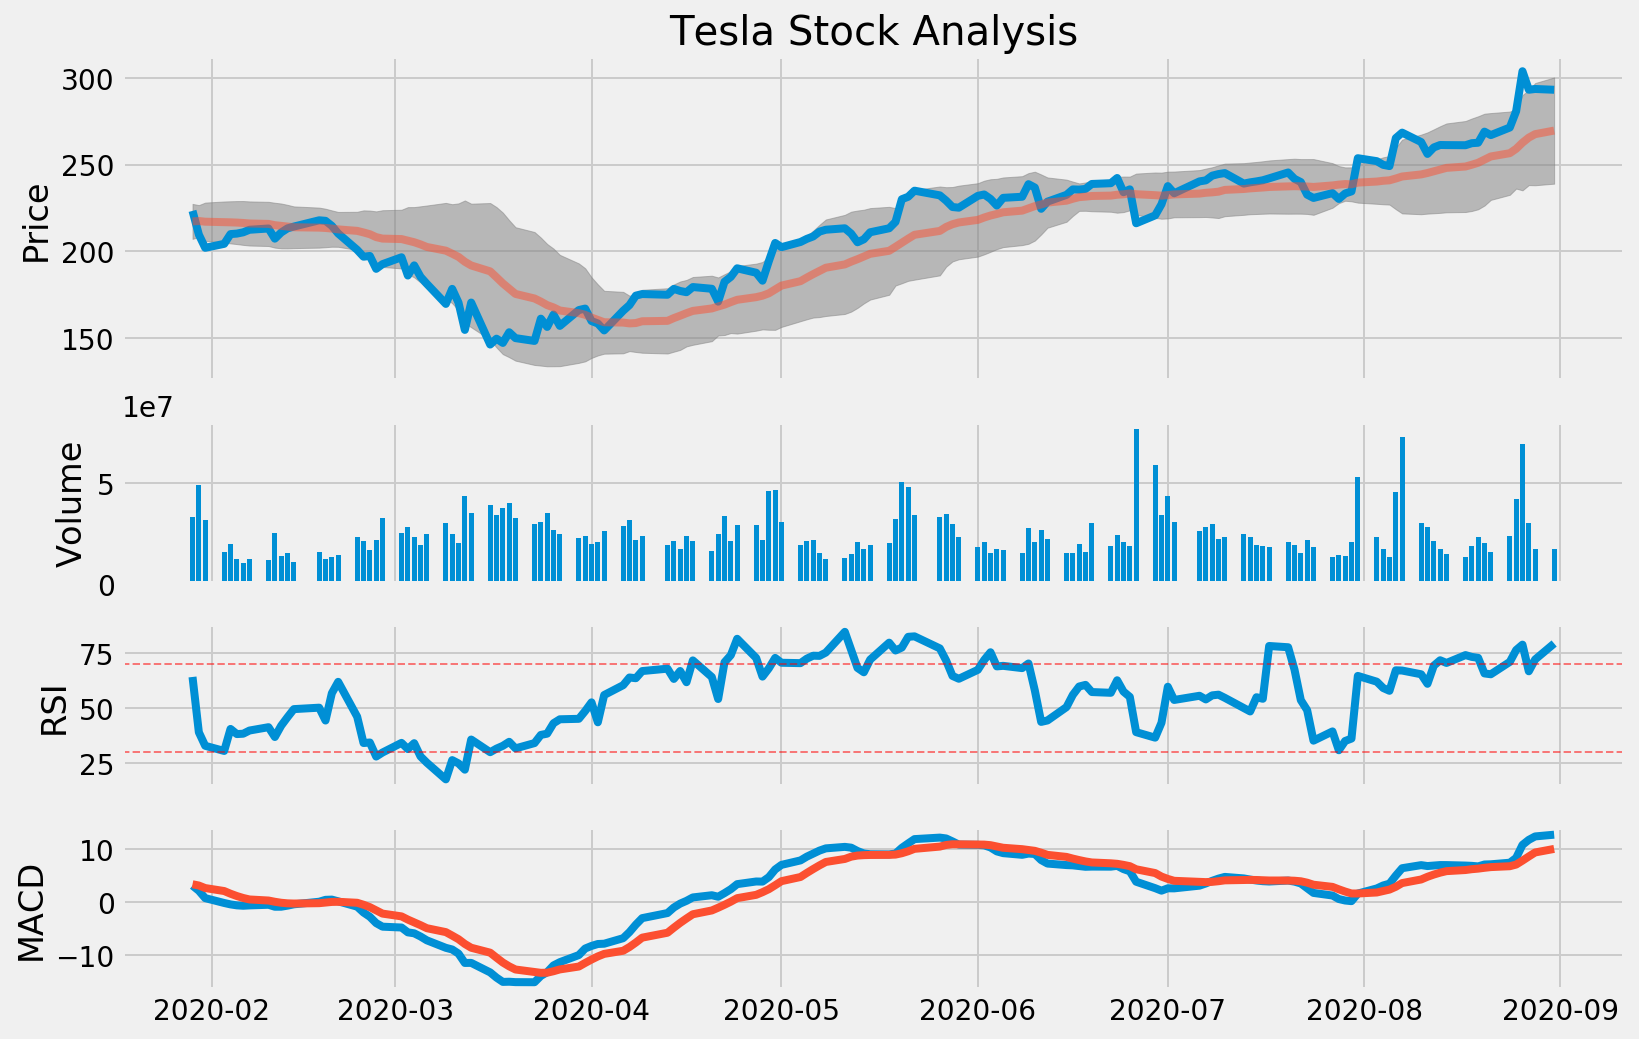

In [71]:
plot_stock(tsla_df)

Resorces:
- https://towardsdatascience.com/implementing-macd-in-python-cc9b2280126a
- https://stackoverflow.com/questions/37737538/merge-matplotlib-subplots-with-shared-x-axis
- https://towardsdatascience.com/implementing-moving-averages-in-python-1ad28e636f9d
- https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300
- https://en.wikipedia.org/wiki/Money_flow_index
- https://school.stockcharts.com/doku.php?id=technical_indicators:money_flow_index_mfi

### Testing functions

In [46]:
tsla_df = get_price('TSLA', '2019-06-06', '2020-08-30')

In [47]:
tsla_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-05,39.736000,40.256001,38.369999,39.318001,39.318001,67554000
2019-06-06,40.888000,42.200001,40.360001,41.189999,41.189999,101211000
2019-06-07,41.000000,42.167999,40.700001,40.900002,40.900002,80017500
2019-06-10,42.049999,43.388000,41.801998,42.576000,42.576000,52925000
2019-06-11,43.827999,44.180000,42.700001,43.419998,43.419998,58267500
...,...,...,...,...,...,...
2020-08-24,425.256012,425.799988,385.503998,402.839996,402.839996,100318000
2020-08-25,394.977997,405.589996,393.600006,404.667999,404.667999,53294500
2020-08-26,412.000000,433.200012,410.726013,430.634003,430.634003,71197000


In [8]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313 entries, 2019-06-05 to 2020-08-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  313 non-null    float64
 1   Volume     313 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 7.3 KB


In [29]:
test = get_SME(tsla_df, 20, 50)

In [30]:
test.head(25)

,Adj Close,Volume,SMA_20,SMA_50
Date,,,,
2019-06-05,39.318001,67554000,NaN,NaN
2019-06-06,41.189999,101211000,NaN,NaN
2019-06-07,40.900002,80017500,NaN,NaN
2019-06-10,42.576000,52925000,NaN,NaN
2019-06-11,43.419998,58267500,NaN,NaN
2019-06-12,41.852001,75987500,NaN,NaN
2019-06-13,42.782001,40841500,NaN,NaN
2019-06-14,42.984001,37167000,NaN,NaN
2019-06-17,45.006001,61584000,NaN,NaN


In [40]:
test = get_EMA(test, 12, 16)

In [41]:
test.head(25)

,Adj Close,Volume,SMA_20,SMA_50,EMA_12,EMA_16
Date,,,,,,
2019-06-05,39.318001,67554000,NaN,NaN,39.318001,39.318001
2019-06-06,41.189999,101211000,NaN,NaN,39.606000,39.538236
2019-06-07,40.900002,80017500,NaN,NaN,39.805078,39.698444
2019-06-10,42.576000,52925000,NaN,NaN,40.231373,40.036980
2019-06-11,43.419998,58267500,NaN,NaN,40.721931,40.434982
2019-06-12,41.852001,75987500,NaN,NaN,40.895788,40.601690
2019-06-13,42.782001,40841500,NaN,NaN,41.185975,40.858197
2019-06-14,42.984001,37167000,NaN,NaN,41.462594,41.108292
2019-06-17,45.006001,61584000,NaN,NaN,42.007734,41.566846


In [44]:
get_Boll(test).head(25)

,Adj Close,Volume,SMA_20,SMA_50,EMA_12,EMA_16,SMA_Boll,std_Boll,upper_Boll,lower_Boll
Date,,,,,,,,,,
2019-06-05,39.318001,67554000,NaN,NaN,39.318001,39.318001,NaN,NaN,NaN,NaN
2019-06-06,41.189999,101211000,NaN,NaN,39.606000,39.538236,NaN,NaN,NaN,NaN
2019-06-07,40.900002,80017500,NaN,NaN,39.805078,39.698444,NaN,NaN,NaN,NaN
2019-06-10,42.576000,52925000,NaN,NaN,40.231373,40.036980,NaN,NaN,NaN,NaN
2019-06-11,43.419998,58267500,NaN,NaN,40.721931,40.434982,NaN,NaN,NaN,NaN
2019-06-12,41.852001,75987500,NaN,NaN,40.895788,40.601690,NaN,NaN,NaN,NaN
2019-06-13,42.782001,40841500,NaN,NaN,41.185975,40.858197,NaN,NaN,NaN,NaN
2019-06-14,42.984001,37167000,NaN,NaN,41.462594,41.108292,NaN,NaN,NaN,NaN
2019-06-17,45.006001,61584000,NaN,NaN,42.007734,41.566846,NaN,NaN,NaN,NaN
